In [1]:
# A Notebook Representing the "State of the Art" for the Simulations and Symmetries Paper
# Expected to be run in a directory where the github "LBEmulator" is a subdirectory

In [2]:
import numpy as np

from scipy.optimize import curve_fit

from matplotlib import pyplot as plt

In [3]:
##### set plot params ######
SMALL_SIZE = 8
BIGGER_SIZE = 12
BIGGEST_SIZE = 14

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGEST_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGEST_SIZE)  # fontsize of the figure title

colors = ['C0','C1','C2','C3','C4']

In [4]:
# Define the model(s)
def combine_nbody_components(spectra,b1,b2,bs,alpha,auto=True):
    
    if auto:
        model = (spectra[:,1] + 2*b1*spectra[:,2] + b1**2 * spectra[:,6] \
            + 2*b2*spectra[:,3] + 2*b1*b2*spectra[:,7] + b2**2 * spectra[:,10] \
            + 2*bs*spectra[:,4] + 2*b1*bs*spectra[:,8] + 2*b2*bs*spectra[:,11] + bs**2*spectra[:,13]\
            + 2*alpha*spectra[:,5] + 2*b1*alpha*spectra[:,9] + 2*b2*alpha*spectra[:,12] + 2*bs*alpha*spectra[:,14])
    else:
        model = (spectra[:,1] + b1*spectra[:,2] \
            + b2*spectra[:,3] \
            + bs*spectra[:,4] \
            + alpha*spectra[:,5])
    return model

def getmodel_interp(k, spec, b1,b2,bs,alpha,auto=True):
    return np.interp(k, spec[:,0], combine_nbody_components(spec,b1,b2,bs,alpha,auto=auto))

def getmodel_joint(k,spec,b1,b2,bs,alpha,s):
    return np.concatenate( (s+getmodel_interp(k,spec,b1,b2,bs,alpha,auto=True),getmodel_interp(k,spec,b1,b2,bs,alpha,auto=False))  )

def simple_bias_model(k, spec, s, a0, a1, a2):
    bias = a0 + a1*spectra[:,0] + a2*spectra[:,0]**2
    phh = np.interp(k, spec[:,0], bias**2 * spec[:,1] + s)
    phm = np.interp(k, spec[:,0], bias * spec[:,1])
    
    return np.concatenate((phh,phm))

def linear_bias_model(k, spec, s, b): 
    bias = b 
    phh = np.interp(k, spec[:,0], bias**2 * spec[:,1] + s)
    phm = np.interp(k, spec[:,0], bias * spec[:,1])
    
    return np.concatenate((phh,phm))

def fitmodel_joint(spec, k, phh, phm, kmax=0.5, model='lemu'):
    dk = k[5] - k[4]; dV = k**2 * dk
    krange = (k > 0.02) * (k < kmax)
    
    pmm = np.interp(k, spec[:,0], spec[:,1])
    #c_hh = (2 * phh**2 / dV)[krange]
    #c_hm = ((phh * pmm + phm**2) / dV)[krange]
    #c_x  = (2 * phh * phm / dV)[krange]
    
    c_hh = (1 / dV)[krange]
    c_hm = (1/ dV)[krange]
    c_x  = (0 / dV)[krange]
    
    N = np.sum(krange)
    cov = np.zeros((2*N,2*N))
    cov[0:N,0:N] = np.diag(c_hh)
    cov[N:,N:] = np.diag(c_hm)
    cov[0:N,N:] = np.diag(c_x); cov[N:,0:N] = np.diag(c_x)
    
    #sigmas = np.sqrt(2*pk**2/dV)
    
    if model == 'lemu':
        func = lambda x, b1, b2, bs, alpha, s: getmodel_joint(x, spec, b1,b2,bs,alpha,s)
        res = curve_fit(func,k[krange],np.concatenate( (phh[krange],phm[krange]) )\
                    ,p0=[0,0,0,0,1000], sigma = cov)[0]
    elif model == 'simple':
        print('Fitting using model' + model)
        func = lambda x, s, a0, a1, a2: simple_bias_model(x, spec, s, a0, a1, a2)
        res = curve_fit(func,k[krange],np.concatenate( (phh[krange],phm[krange]) )\
                        ,p0=[1000,1,0,0], sigma = cov)[0]
    else:
        print('Fitting using model' + model)
        func = lambda x, s, a0: linear_bias_model(x, spec, s, a0)
        res = curve_fit(func,k[krange],np.concatenate( (phh[krange],phm[krange]) )\
                        ,p0=[1000,1], sigma = cov)[0]
    
    
    return res, k, func(k,*res)


In [5]:
# Get the data files:
zs = [0,1]

halo_files = [['../data/ph_12.00_12.50_z000.txt',\
            '../data/ph_12.50_13.00_z000.txt',\
               '../data/ph_13.00_13.50_z000.txt'],\
              ['../data/ph_12.00_12.50_z100.txt',\
               '../data/ph_12.50_13.00_z100.txt',\
               '../data/ph_13.00_13.50_z100.txt']]

spectra_files  = ['../data/pc_z000_R0.txt','../data/pc_z100_R0.txt']

z | logMmin logMmax | b1 b2 bs bk | SN
0 (12.0, 12.5) [-0.19924548 -0.28342896  0.07878051 -0.66085799] 295.5057155891255
0 (12.5, 13.0) [-0.11131258  0.2060761   0.2898513   4.24398542] 1005.7447254767641
0 (13.0, 13.5) [ 0.09782143 -0.14743752 -0.43208424  1.86073197] 2911.148461775513
1 (12.0, 12.5) [ 0.3053327  -0.05251328 -0.79262326  1.17880621] 447.5260171507071
1 (12.5, 13.0) [ 0.69410457  0.14697939 -1.12122487  1.63025763] 1145.4389196875877
1 (13.0, 13.5) [ 1.35596215  0.78782174 -0.29373526  1.52556377] 3373.6334082549156


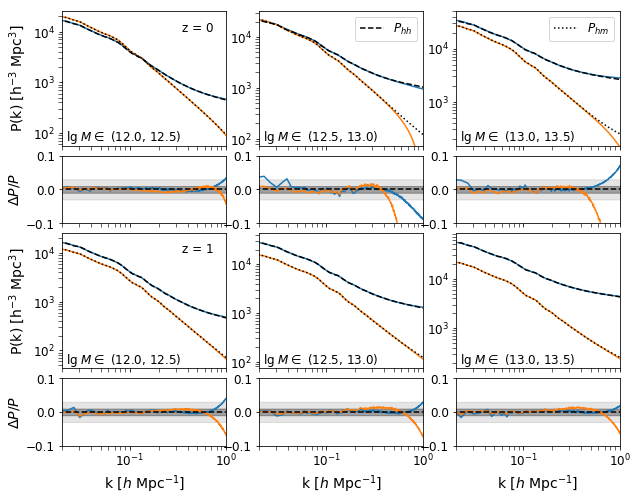

In [6]:
Mbins = [(12.0,12.5),(12.5,13.0),(13.0,13.5)]

f, axs = plt.subplots(figsize=(10,8),ncols=len(Mbins),nrows=2*len(zs),gridspec_kw={'hspace':0.1,'height_ratios':(2,1)*len(zs)})

kmaxs = [0.5]


counter = 0

print('z | logMmin logMmax | b1 b2 bs bk | SN')

for ii, z in enumerate(zs):
    
    spectra = np.loadtxt(spectra_files[ii])
    
    for jj, Mbin in enumerate(Mbins):

        k, phh, pherr, phm, phmerr = np.loadtxt(halo_files[ii][jj]).T
        plotrange = (k > 0.01) * (k<1.)
        #phh -= sn
        #axs[2*ii,jj].loglog(k,phh,'k')
        #axs[2*ii,jj].loglog(k,phm,'k--')
        
        for kk, kmax in enumerate(kmaxs):
            
            kmax = (z > 0.1) * 0.8 + (z<=0.1)*0.45
            
            if jj == 0:
                kmax = 0.75
            
            a,b,c = fitmodel_joint(spectra,k,phh,phm,kmax=kmax)
            phhemu = c[:1023]
            phmemu = c[1023:]
            
            np.savetxt('../data/pth_z_%.1f_M_%.1f_%.1f.dat'%(z,Mbin[0],Mbin[1]),np.array([b,phhemu,phmemu]).T, header='k | Phh | Phm')
                        
            print(z,Mbin,a[:-1],a[-1])
            
            axs[2*ii,jj].loglog(b,phhemu)
            axs[2*ii,jj].loglog(b,phmemu)
            
            axs[2*ii,jj].loglog(k,phh,'k--')
            axs[2*ii,jj].loglog(k,phm,'k:')
            
            axs[2*ii+1,jj].semilogx(k,(phhemu-phh)/phh)
            axs[2*ii+1,jj].semilogx(k,(phmemu-phm)/phm)
            
            axs[2*ii,jj].tick_params(which='minor', length=4)
            axs[2*ii+1,jj].tick_params(which='minor', length=4)
            
        
        axs[2*ii+1,jj].semilogx(k, 0*k, 'k--')
         
        axs[2*ii,jj].set_xlim(0.02,1.01)
        axs[2*ii+1,jj].set_xlim(0.02,1.01)
        axs[2*ii,jj].set_ylim(0.6*np.min(phm[plotrange]),1.5*np.max(phh))
        
        axs[2*ii+1,jj].fill_between(k,-0.03,0.03,color='k',alpha=0.1)
        axs[2*ii+1,jj].fill_between(k,-0.01,0.01,color='k',alpha=0.3)
        axs[2*ii+1,jj].set_ylim(-0.1,0.1)
        
        axs[2*ii,jj].text(0.022, 0.75*np.min(phm[plotrange]), r'${\rm lg}\ M \in$ (%.1f, %.1f)' %(Mbin[0],Mbin[1]))
        
        counter += 1

            
# Do labels and axis labels separately

axs[0,1].loglog(k, k, c='k',ls='--', label=r'$P_{hh}$')
axs[0,1].legend()

axs[0,2].loglog(k, k, c='k', ls=':', label=r'$P_{hm}$')
axs[0,2].legend()

axs[0,0].text(0.35,1e4,'z = 0')
axs[2,0].text(0.35,1e4,'z = 1')

for ii in range(len(Mbins)):
    axs[-1,ii].set_xlabel(r'k [$h$ Mpc$^{-1}$]')

for ii in range(len(zs)):
    axs[2*ii,0].set_ylabel(r'P(k) [h$^{-3}$ Mpc$^{3}$]')
    axs[2*ii+1,0].set_ylabel(r'$\Delta P / P$')

for ii in range(len(zs)):
    for jj in range(len(Mbins)):
        axs[2*ii,jj].set_xticklabels([])
        if ii != (len(zs)-1):
            axs[2*ii+1,jj].set_xticklabels([])
    

plt.show()